## Preprocessing

In [170]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,roc_curve,auc,f1_score,confusion_matrix

import gensim
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GRU, BatchNormalization, Conv1D, GlobalMaxPooling1D

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [171]:
df = pd.read_csv('SpamVsHam.tsv', delimiter='\t', header=None, names=['Label', 'Message'])
print(df.head())
print("Shape : ", df.shape, "\n")
print(df.info())
print("\n Class distribution :", df['Label'].value_counts())

##?? we should have 4827 ham data, right? At least the pdf says.
##but only have 4825

  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Shape :  (5572, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

 Class distribution : Label
ham     4825
spam     747
Name: count, dtype: int64


In [172]:
## preprocess
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    text = ' '.join(tokens)
    return text

df['Message'] = df['Message'].apply(preprocess)

print("Cleaned text:", df.head())

Cleaned text:   Label                                            Message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry 2 wkly comp win fa cup final tkts 2...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


## Feature Extraction Techniques

In [173]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Message']).toarray()

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (5572, 5000)


In [174]:
#Word2Vec
TokenTexts = df['Message'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=TokenTexts, vector_size=100, window=5, min_count=1, workers=2)
#Try relatively default parameters for word2vec.

def vectorize(text, model):
    vector = np.zeros(model.vector_size)
    n_words = 0

    for word in word_tokenize(text):
        if word in model.wv:
            vector += model.wv[word]
            n_words += 1

    if n_words > 0:
        vector /= n_words 
    return vector

X_word2vec = np.array([vectorize(text, word2vec_model) for text in df['Message']])
print("Word2Vec shape:", X_word2vec.shape)

Word2Vec shape: (5572, 100)


## Modeling: Random Forest (TF-IDF)

In [91]:
X = X_tfidf  
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
print("Unique labels after conversion:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
print("Unique classes in y_train:", unique_classes_train)
print("Unique classes in y_test:", unique_classes_test) 

Unique labels after conversion: [0 1]
Unique classes in y_train: [0 1]
Unique classes in y_test: [0 1]


In [92]:
rf_classifier = RandomForestClassifier(n_estimators=37, criterion = 'entropy', random_state=1)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#estimator= 100 => 97.67%
#estimator= 37 => 97.67%

Accuracy: 0.9736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1448
           1       1.00      0.80      0.89       224

    accuracy                           0.97      1672
   macro avg       0.99      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672



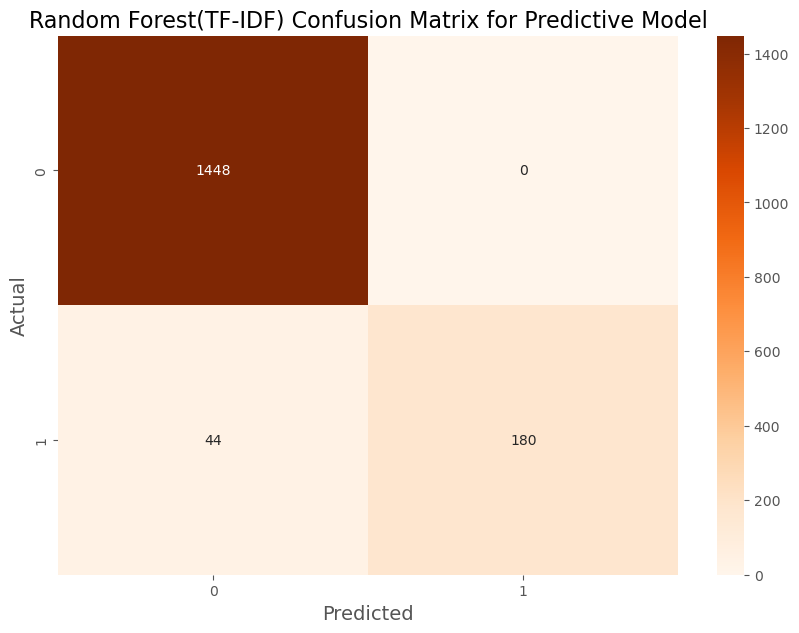

0.9736842105263158

In [13]:
cm = confusion_matrix(y_test, y_pred)


# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Oranges', fmt='g')
plt.title('Random Forest(TF-IDF) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

In [54]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

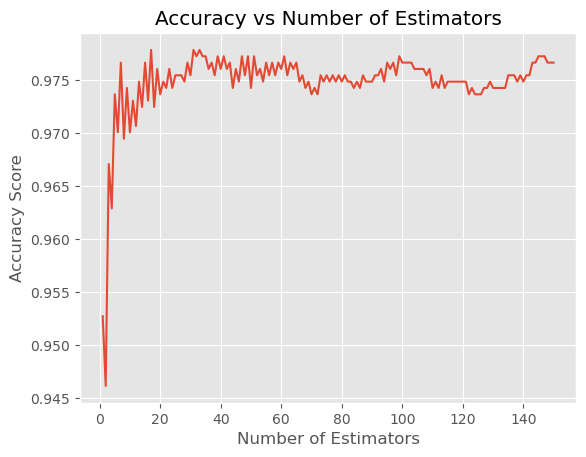

In [55]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [57]:
parameter = {'n_estimators': range(5, 41)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")


The best number of estimators is: 37


## Modeling: Random Forest (Word2Vec)

In [102]:
X = X_word2vec
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=47, criterion = 'entropy', random_state=1) 
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#estimators = 100 => 94.85%
#estimators = 47  => 94.8%

Accuracy: 0.94377990430622

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1448
           1       0.98      0.59      0.74       224

    accuracy                           0.94      1672
   macro avg       0.96      0.80      0.85      1672
weighted avg       0.95      0.94      0.94      1672



In [16]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

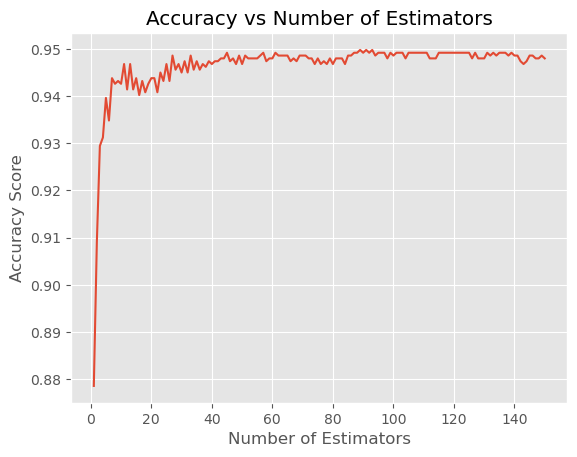

In [17]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [18]:

parameter = {'n_estimators': range(20, 50)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")


The best number of estimators is: 47


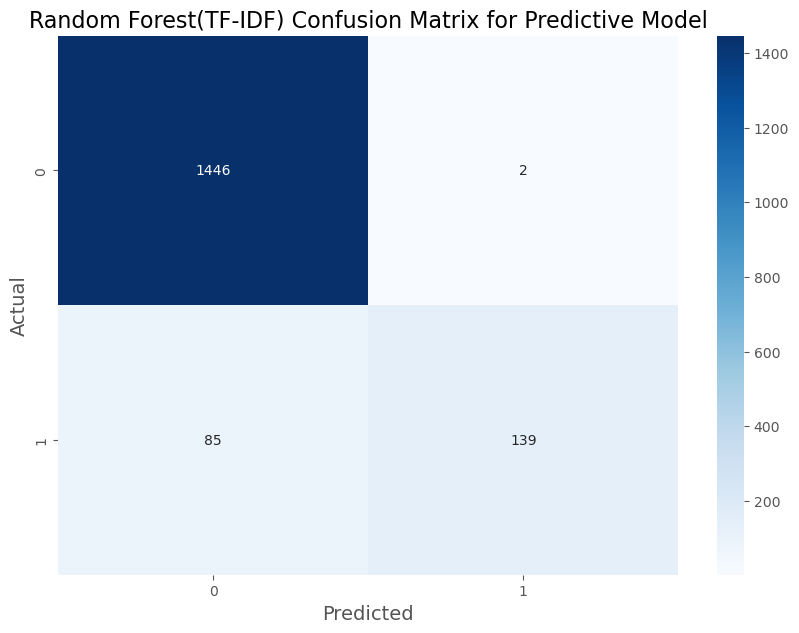

0.9479665071770335

In [21]:
cm = confusion_matrix(y_test, y_pred)


# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Blues', fmt='g')
plt.title('Random Forest(TF-IDF) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Message'])
sequences = tokenizer.texts_to_sequences(df['Message'])
max_length = max(len(x) for x in sequences)  
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42, stratify=y)


In [24]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10


49/49 [==============================] - 7s 82ms/step - loss: 0.4202 - accuracy: 0.8587 - val_loss: 0.4049 - val_accuracy: 0.8628
Epoch 2/10
49/49 [==============================] - 3s 65ms/step - loss: 0.3941 - accuracy: 0.8667 - val_loss: 0.4009 - val_accuracy: 0.8628
Epoch 3/10
49/49 [==============================] - 3s 65ms/step - loss: 0.3937 - accuracy: 0.8667 - val_loss: 0.4007 - val_accuracy: 0.8628
Epoch 4/10
49/49 [==============================] - 3s 62ms/step - loss: 0.3950 - accuracy: 0.8667 - val_loss: 0.4021 - val_accuracy: 0.8628
Epoch 5/10
49/49 [==============================] - 3s 64ms/step - loss: 0.3950 - accuracy: 0.8667 - val_loss: 0.3998 - val_accuracy: 0.8628
Epoch 6/10
49/49 [==============================] - 3s 63ms/step - loss: 0.3933 - accuracy: 0.8667 - val_loss: 0.4000 - val_accuracy: 0.8628
Epoch 7/10
49/49 [==============================] - 3s 63ms/step - loss: 0.3940 - accuracy: 0.8667 - val_loss: 0.3999 - val_accuracy: 0.8628
Epoch 8/10


In [42]:
from sklearn.utils.class_weight import compute_class_weight

# 计算类权重
labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=labels, y=y_train)
class_weight_dict = dict(zip(labels, class_weights))

# 在模型训练时加入 class_weight
history = model.fit(X_train, y_train, class_weight=class_weight_dict, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 0.7252 - accuracy: 0.6297 - val_loss: 0.7031 - val_accuracy: 0.3379
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.4859 - val_loss: 0.7183 - val_accuracy: 0.3343
Epoch 3/10
61/61 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.5718 - val_loss: 0.7170 - val_accuracy: 0.3672
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.4438 - val_loss: 0.6145 - val_accuracy: 0.6172
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6521 - accuracy: 0.4949 - val_loss: 0.6414 - val_accuracy: 0.5108
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6495 - accuracy: 0.5318 - val_loss: 0.6197 - val_accuracy: 0.5646
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.5041 - val_loss: 0.6014 - val_accuracy: 0.6035
Epoch 8/10
61/61 [==

In [26]:
results = model.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


53/53 [==============================] - 1s 17ms/step - loss: 0.3982 - accuracy: 0.8660
Test Loss, Test Accuracy: [0.3982389271259308, 0.8660287261009216]


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [32]:

input_length = X_tfidf.shape[1]  # 特徵數量

# 建立模型
input_layer = Input(shape=(input_length, 1))
lstm_layer = LSTM(64, return_sequences=False)(input_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 由於 LSTM 期望三維輸入 [樣本數, 時間步長, 特徵數]，我們需要將輸入數據 X_tfidf 改變形狀
X_tfidf_reshaped = np.expand_dims(X_tfidf, axis=2)

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_reshaped, y, test_size=0.3, random_state=42, stratify=y)

# 訓練模型
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 評估模型
results = model.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Epoch 1/10
49/49 [==============================] - 192s 4s/step - loss: 0.4728 - accuracy: 0.8654 - val_loss: 0.4003 - val_accuracy: 0.8628
Epoch 2/10
49/49 [==============================] - 190s 4s/step - loss: 0.3944 - accuracy: 0.8667 - val_loss: 0.3998 - val_accuracy: 0.8628
Epoch 3/10
49/49 [==============================] - 189s 4s/step - loss: 0.3946 - accuracy: 0.8667 - val_loss: 0.4000 - val_accuracy: 0.8628
Epoch 4/10
49/49 [==============================] - 186s 4s/step - loss: 0.3928 - accuracy: 0.8667 - val_loss: 0.4001 - val_accuracy: 0.8628
Epoch 5/10
 4/49 [=>............................] - ETA: 2:48 - loss: 0.4383 - accuracy: 0.8438

KeyboardInterrupt: 

In [36]:

# 假設你已經有了 X_tfidf 和相應的標籤 y
input_length = X_tfidf.shape[1]  # 特徵數量

# 建立模型
input_layer = Input(shape=(input_length, 1))
gru_layer = GRU(64, return_sequences=False)(input_layer)
output_layer = Dense(1, activation='sigmoid')(gru_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 調整數據形狀
X_tfidf_reshaped = np.expand_dims(X_tfidf, axis=2)

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_reshaped, y, test_size=0.3, random_state=42, stratify=y)

# 訓練模型
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# 評估模型
results = model.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)

Epoch 1/10
61/61 [==============================] - 365s 6s/step - loss: 0.4634 - accuracy: 0.8662 - val_loss: 0.3958 - val_accuracy: 0.8660
Epoch 2/10
61/61 [==============================] - 306s 5s/step - loss: 0.3951 - accuracy: 0.8659 - val_loss: 0.3970 - val_accuracy: 0.8660
Epoch 3/10
 3/61 [>.............................] - ETA: 3:25 - loss: 0.3566 - accuracy: 0.8854

KeyboardInterrupt: 

In [37]:

# 假設你已經有了 X_word2vec 和相應的標籤 y
input_length = X_word2vec.shape[1]  # 特徵數量
X_word2vec_reshaped = np.expand_dims(X_word2vec, axis=1)

input_length = X_word2vec.shape[1]  # 特徵數量

# 建立模型
input_layer = Input(shape=(1, input_length))
gru_layer = GRU(64, return_sequences=False)(input_layer)
output_layer = Dense(1, activation='sigmoid')(gru_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_reshaped, y, test_size=0.3, random_state=42, stratify=y)

# 訓練模型
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# 評估模型
results = model.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Epoch 1/10
61/61 [==============================] - 2s 7ms/step - loss: 0.4565 - accuracy: 0.8659 - val_loss: 0.4172 - val_accuracy: 0.8660
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4147 - accuracy: 0.8659 - val_loss: 0.4115 - val_accuracy: 0.8660
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4098 - accuracy: 0.8659 - val_loss: 0.4062 - val_accuracy: 0.8660
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4043 - accuracy: 0.8659 - val_loss: 0.4026 - val_accuracy: 0.8660
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8659 - val_loss: 0.3982 - val_accuracy: 0.8660
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3972 - accuracy: 0.8659 - val_loss: 0.3951 - val_accuracy: 0.8660
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3948 - accuracy: 0.8659 - val_loss: 0.3926 - val_accuracy: 0.8660
Epoch 8/10
61/61 [==

## CNN

In [117]:
from sklearn.utils.class_weight import compute_class_weight
X_tfidf_reshaped = np.expand_dims(X_tfidf, axis=2) 

print("Reshaped TF-IDF shape:", X_tfidf_reshaped.shape)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

modelCNNTF = Sequential()
modelCNNTF.add(Conv1D(128, 5, activation='relu', input_shape=(X_tfidf_reshaped.shape[1], 1)))
modelCNNTF.add(BatchNormalization())
modelCNNTF.add(GlobalMaxPooling1D())
modelCNNTF.add(Dense(10, activation='relu'))
modelCNNTF.add(BatchNormalization())
modelCNNTF.add(Dense(1, activation='sigmoid'))

modelCNNTF.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X_tfidf_reshaped, y, test_size=0.3, random_state=1, stratify=y)
modelCNNTF.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weight_dict)

results = modelCNNTF.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Reshaped TF-IDF shape: (5572, 5000, 1)
Epoch 1/10
61/61 [==============================] - 18s 279ms/step - loss: 0.6366 - accuracy: 0.6115 - val_loss: 0.5572 - val_accuracy: 0.8660
Epoch 2/10
61/61 [==============================] - 16s 269ms/step - loss: 0.5377 - accuracy: 0.6951 - val_loss: 0.5043 - val_accuracy: 0.8660
Epoch 3/10
61/61 [==============================] - 17s 280ms/step - loss: 0.5259 - accuracy: 0.7479 - val_loss: 0.4569 - val_accuracy: 0.8660
Epoch 4/10
61/61 [==============================] - 17s 275ms/step - loss: 0.5272 - accuracy: 0.6990 - val_loss: 0.4180 - val_accuracy: 0.8660
Epoch 5/10
61/61 [==============================] - 17s 275ms/step - loss: 0.5186 - accuracy: 0.7179 - val_loss: 0.3831 - val_accuracy: 0.8660
Epoch 6/10
61/61 [==============================] - 16s 270ms/step - loss: 0.5180 - accuracy: 0.7246 - val_loss: 0.3676 - val_accuracy: 0.8660
Epoch 7/10
61/61 [==============================] - 16s 269ms/step - loss: 0.5142 - accuracy: 0.7367 - 

In [182]:
X_word2vec_reshaped = np.expand_dims(X_word2vec, axis=2)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

modelCNNW2V = Sequential()
modelCNNW2V.add(Conv1D(128, 5, activation='relu', input_shape=(X_word2vec_reshaped.shape[1], 1)))
modelCNNW2V.add(BatchNormalization())
modelCNNW2V.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
modelCNNW2V.add(Dense(10, activation='relu'))
modelCNNW2V.add(Dense(1, activation='sigmoid'))

modelCNNW2V.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_reshaped, y, test_size=0.2, random_state=1, stratify=y)
modelCNNW2V.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# 评估模型
results = modelCNNW2V.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Epoch 1/10
140/140 [==============================] - 1s 5ms/step - loss: 0.6799 - accuracy: 0.7483 - val_loss: 0.6542 - val_accuracy: 0.7641
Epoch 2/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6693 - accuracy: 0.5647 - val_loss: 0.6961 - val_accuracy: 0.3130
Epoch 3/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6663 - accuracy: 0.5125 - val_loss: 0.6550 - val_accuracy: 0.5148
Epoch 4/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6594 - accuracy: 0.5513 - val_loss: 0.7028 - val_accuracy: 0.3148
Epoch 5/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6580 - accuracy: 0.4680 - val_loss: 0.6873 - val_accuracy: 0.3561
Epoch 6/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6531 - accuracy: 0.5024 - val_loss: 0.6528 - val_accuracy: 0.4547
Epoch 7/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6545 - accuracy: 0.4902 - val_loss: 0.6457 - val_accuracy: 0.4368
Epoch 

## SPAM Generation

In [64]:
spam_msg = df[df['Label'] == 'spam']['Message']
spam_msg = spam_msg.apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))


In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spam_msg)
sequences = tokenizer.texts_to_sequences(spam_msg)
seq_length = 10

train_sequences = []
for sequence in sequences:
    for i in range(seq_length, len(sequence)):
        train_sequences.append(sequence[i-seq_length:i+1])

train_sequences = pad_sequences(train_sequences, maxlen=seq_length+1, padding='pre')
train_sequences = np.array(train_sequences)
X, y = train_sequences[:, :-1], train_sequences[:, -1]
y = to_categorical(y, num_classes=len(tokenizer.word_index)+1)


In [70]:

Vsize = len(tokenizer.word_index) + 1

modelSPAM = Sequential()
modelSPAM.add(Embedding(Vsize, 50, input_length=seq_length))
modelSPAM.add(LSTM(150, return_sequences=True))
modelSPAM.add(LSTM(150))
modelSPAM.add(Dense(150, activation='relu'))
modelSPAM.add(Dense(Vsize, activation='softmax'))

modelSPAM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelSPAM.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
42/42 [==============================] - 3s 24ms/step - loss: 7.5025 - accuracy: 0.0291
Epoch 2/100
42/42 [==============================] - 1s 24ms/step - loss: 6.7655 - accuracy: 0.0330
Epoch 3/100
42/42 [==============================] - 1s 27ms/step - loss: 6.6148 - accuracy: 0.0330
Epoch 4/100
42/42 [==============================] - 1s 24ms/step - loss: 6.5182 - accuracy: 0.0332
Epoch 5/100
42/42 [==============================] - 1s 24ms/step - loss: 6.4169 - accuracy: 0.0332
Epoch 6/100
42/42 [==============================] - 1s 24ms/step - loss: 6.2741 - accuracy: 0.0336
Epoch 7/100
42/42 [==============================] - 1s 27ms/step - loss: 6.1228 - accuracy: 0.0362
Epoch 8/100
42/42 [==============================] - 1s 26ms/step - loss: 6.0026 - accuracy: 0.0404
Epoch 9/100
42/42 [==============================] - 1s 27ms/step - loss: 5.8859 - accuracy: 0.0409
Epoch 10/100
42/42 [==============================] - 1s 25ms/step - loss: 5.7891 - accuracy: 0.0417

In [80]:
def generate_text(model, tokenizer, seq_length, seed_text, num_gen_words):
    output_text = []
    input_text = seed_text
    for _ in range(num_gen_words):
        encoded = tokenizer.texts_to_sequences([input_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        
        # 使用 model.predict 获取预测结果，并使用 np.argmax 找到最可能的类别索引
        predictions = model.predict(encoded, verbose=0)
        pred_word_index = np.argmax(predictions, axis=-1)[0]
        pred_word = tokenizer.index_word.get(pred_word_index, '')
        
        input_text += ' ' + pred_word
        output_text.append(pred_word)
    
    return ' '.join(output_text)

# 生成新的 SPAM-like 邮件
generated_texts = []
seed_texts = [
    "Today is Jimmy's birthday",
    "winner winner chicken dinner",
    "How can I save a brokenheart within me",
    "Oh girl why you leave me so high to leave me so low, to leave me solo",
    "Oh why, I'm wasting my time, waiting for your call, but damn your so cold"
    ]
for seed in seed_texts:
    new_text = generate_text(model, tokenizer, seq_length, seed, 10)  # 这里生成每条文本的长度为20个单词
    generated_texts.append(new_text)
while len(generated_texts) < 100:
    for seed in seed_texts:
        new_text = generate_text(model, tokenizer, seq_length, seed, 20)
        generated_texts.append(new_text)
        if len(generated_texts) >= 100:
            break

print("Total generated texts:", len(generated_texts))
print(generated_texts[:10])  


Total generated texts: 100
['16 text text send reply club get 83110 83110 87121', 'text november text 25p gift send tones every classic ltd', 'na na wc1n3xx luv reply xx evening sexy minapn rply', 'gift text mins mins £100 charged 0870141701216 £1million 82277 6wu', '0207 send ts cs operator per reply stop end stop', '16 text text send reply club get 83110 83110 87121 burger text 09065069120 adult meet aom england cam correct website', 'text november text 25p gift send tones every classic ltd n 87121 18yrs fun entry get std txt revealed txt', 'na na wc1n3xx luv reply xx evening sexy minapn rply 3mins wc1n3xx 09065989180 bill httpimg fancy giv trywales dream lccltd', 'gift text mins mins £100 charged 0870141701216 £1million 82277 6wu 6wu 7zs good order hot mk45 mk45 cumin 3aj php', '0207 send ts cs operator per reply stop end stop txts info rate text 83355 httpimg 32323 mk45 mk45 2wt']


## SPAM testing

In [84]:
## preprocess
def preprocess(new_text):
    new_text = new_text.lower()
    new_text = new_text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(new_text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    new_text = ' '.join(tokens)
    return new_text

processed_texts = [preprocess(text) for text in generated_texts]

# 打印前5条预处理后的文本
print(processed_texts[:5])

['16 text text send reply club get 83110 83110 87121', 'text november text 25p gift send tones every classic ltd', 'na na wc1n3xx luv reply xx evening sexy minapn rply', 'gift text mins mins £100 charged 0870141701216 £1million 82277 6wu', '0207 send ts cs operator per reply stop end stop']


In [89]:
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

processed_texts_word2vec = np.array([vectorize_text(text, word2vec_model) for text in processed_texts])
processed_texts_tfidf = tfidf_vectorizer.transform(processed_texts)

In [100]:
RF_pred_tfidf = rf_classifier.predict(processed_texts_tfidf)

true_labels = [1] * len(processed_texts)
print(classification_report(true_labels, RF_pred_tfidf))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.39      0.56       100

    accuracy                           0.39       100
   macro avg       0.50      0.20      0.28       100
weighted avg       1.00      0.39      0.56       100



In [104]:
RF_pred_word2vec = rf_classifier.predict(processed_texts_word2vec)
print(classification_report(true_labels, RF_pred_tfidf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.39      0.56       100

    accuracy                           0.39       100
   macro avg       0.50      0.20      0.28       100
weighted avg       1.00      0.39      0.56       100



In [118]:
processed_texts_tfidf_reshaped = np.expand_dims(processed_texts_tfidf.toarray(), axis=2)  # 增加一个维度
predicted_labels = modelCNNTF.predict(processed_texts_tfidf_reshaped)
predicted_labels = (predicted_labels > 0.5).astype(int).flatten()
print(classification_report(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))

4/4 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.19      0.32       100

    accuracy                           0.19       100
   macro avg       0.50      0.10      0.16       100
weighted avg       1.00      0.19      0.32       100

Accuracy: 0.19


In [183]:
processed_texts_word2vec_reshaped = np.expand_dims(processed_texts_word2vec, axis=2)
predicted_labels = modelCNNW2V.predict(processed_texts_word2vec_reshaped)
predicted_labels = (predicted_labels > 0.5).astype(int).flatten()
print(classification_report(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))

4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.41      0.58       100

    accuracy                           0.41       100
   macro avg       0.50      0.20      0.29       100
weighted avg       1.00      0.41      0.58       100

Accuracy: 0.41
